# Water prediction

# Outline
<div class="alert alert-block alert-danger" >

- [ 1 - import libararies & read the data ](#1)
- [2 - Data Augmentation](#2)
- [3 - Model & Training](#3)

<div class="alert alert-block alert-info" >
<a name='1'></a>
    <h1> 1 - import libararies & read the data </h1>
</div>

In [5]:
import numpy as np
import tensorflow as tf
import random
import os
import cv2
from PIL import Image
import tifffile as tiff
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, Add, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization, Activation, Conv2DTranspose, MaxPool2D, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [6]:
# Define the training parameters
EPOCHS = 20
BATCH_SIZE = 8

In [7]:
# Set random seeds for reproducibility
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Ensure reproducibility in environments with multiple threads
os.environ['PYTHONHASHSEED'] = str(SEED)

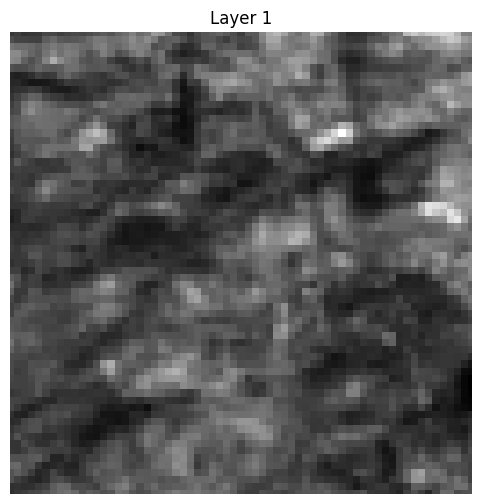

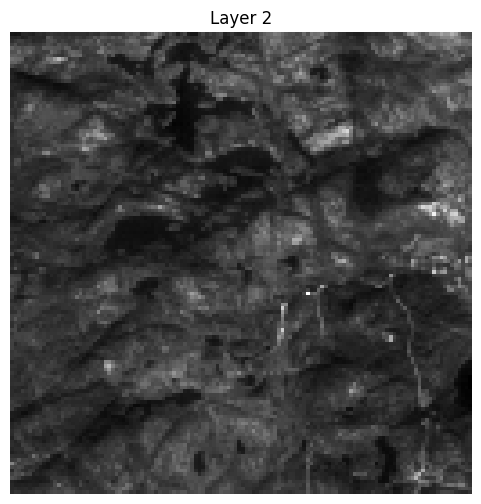

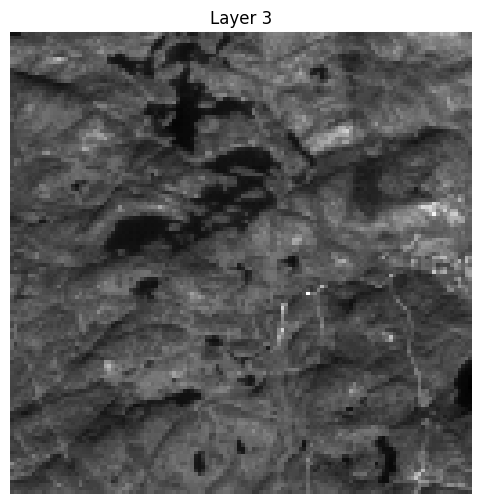

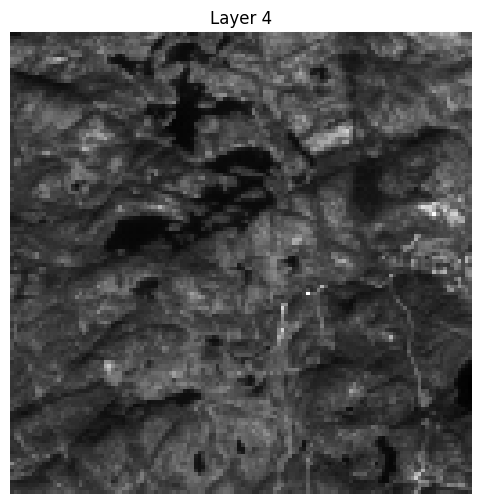

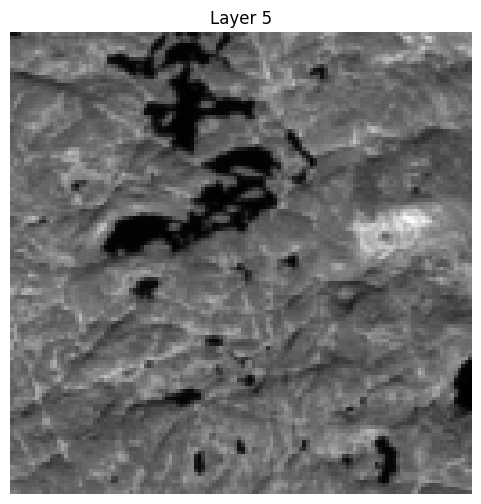

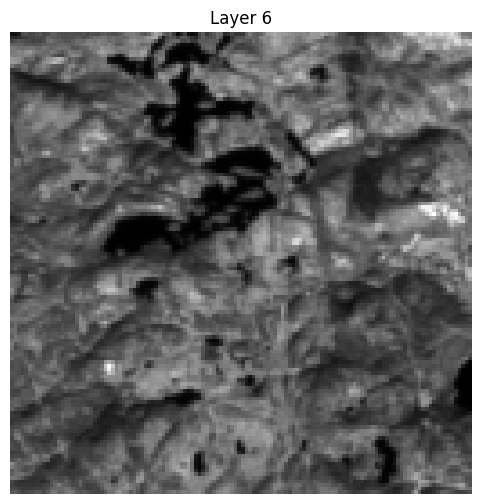

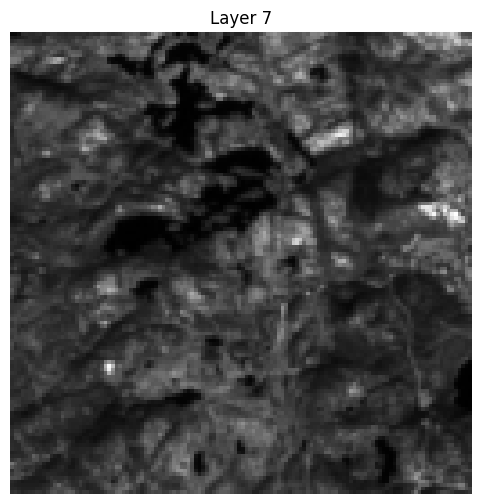

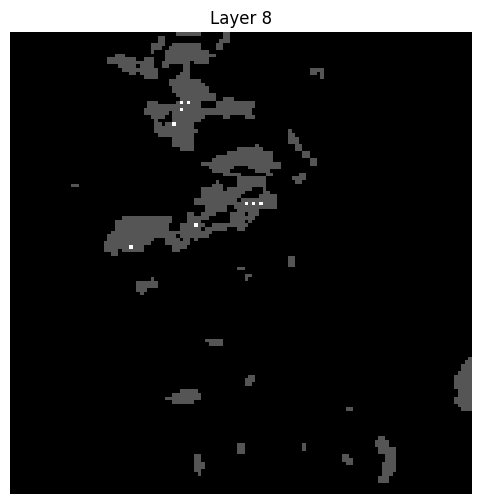

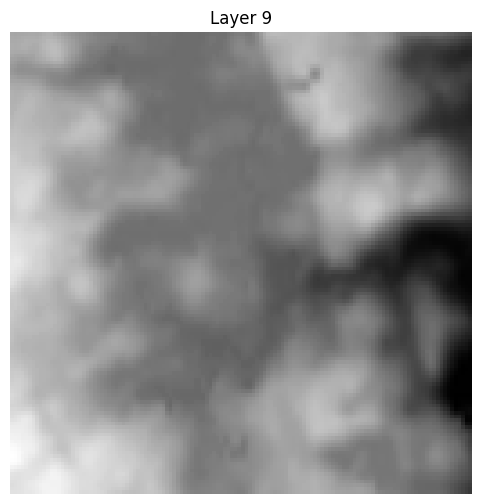

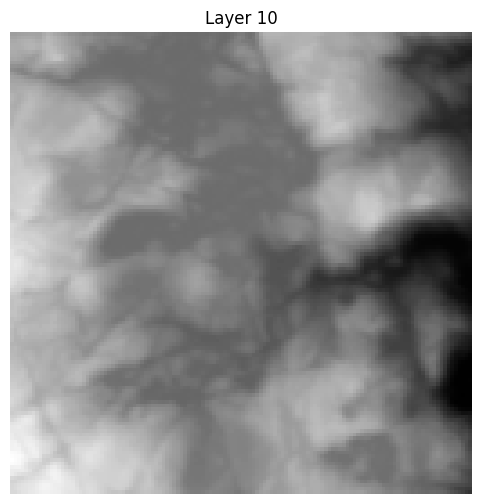

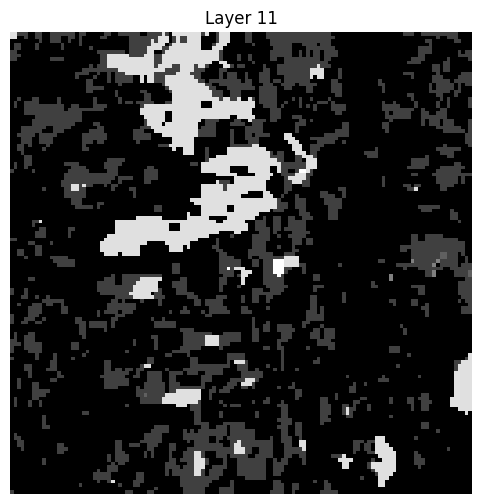

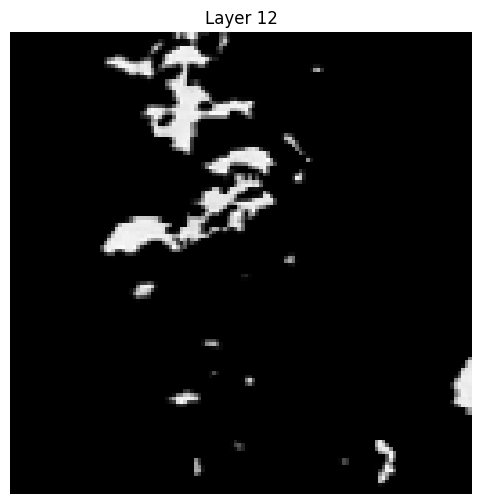

In [8]:
# Read the TIFF file
tif_path = 'data\\images\\0.tif'  # Replace with your TIFF file path
tif_image = tiff.imread(tif_path)

# Check the number of layers
num_layers = tif_image.shape[2]

# Plot each layer
for i in range(num_layers):
    plt.figure(figsize=(6, 6))
    plt.imshow(tif_image[:,:,i], cmap='gray')
    plt.title(f'Layer {i + 1}')
    plt.axis('off')
    plt.show()

In [9]:
tif_image.shape

(128, 128, 12)

In [10]:
rgb_image = tif_image[:,:,1:4]
rgb_image = rgb_image[:,:,::-1]

In [11]:
tif_image[:,:,11].max()

97

In [12]:
# Normalize the image data to the range 0-1
rgb_image = rgb_image.astype(np.float32)
rgb_image -= rgb_image.min()  # Subtract the minimum value
rgb_image /= rgb_image.max()  # Divide by the maximum value

# Scale to the range 0-255
rgb_image *= 255.0

# Convert to uint8 type (optional, depending on the use case)
rgb_image = rgb_image.astype(np.uint8)

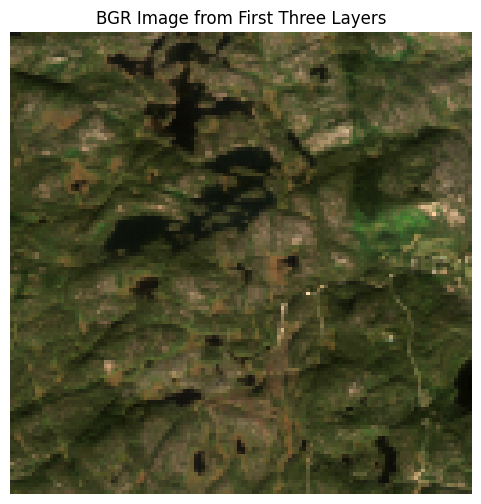

In [13]:
# Plot the BGR image
plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.title('BGR Image from First Three Layers')
plt.axis('off')
plt.show()

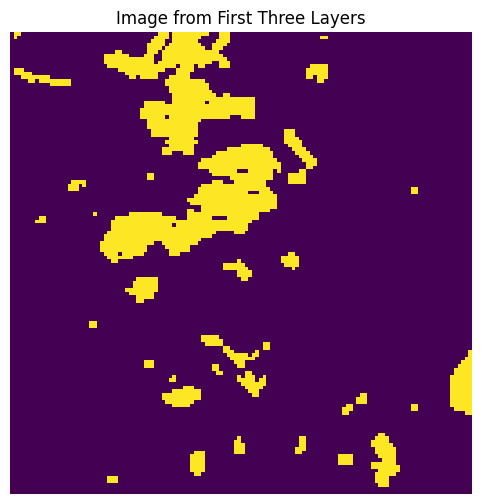

In [14]:
# Read the TIFF file
png_path = 'data\\labels\\0.png'  # Replace with your TIFF file path
png_image = Image.open(png_path)

# Plot the BGR image
plt.figure(figsize=(6, 6))
plt.imshow(png_image)
plt.title('Image from First Three Layers')
plt.axis('off')
plt.show()

In [15]:
def get_max_of_layers(image_dir):
    image_maxs = np.zeros((12,1))
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            image = tiff.imread(image_path)
            
            for i in range(image.shape[2]):
                if image_maxs[i] < image[:,:,i].max():
                    image_maxs[i] = image[:,:,i].max()  
    return image_maxs

image_maxs = get_max_of_layers('data/images')
print(image_maxs)

[[ 6568.]
 [ 9659.]
 [11368.]
 [12041.]
 [15841.]
 [15252.]
 [14647.]
 [  255.]
 [ 4245.]
 [ 4287.]
 [  100.]
 [  111.]]


In [16]:
def get_min_of_layers(image_dir):
    image_mins = np.full((12,1),100000)
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            image = tiff.imread(image_path)
            
            for i in range(image.shape[2]):
                if image_mins[i] > image[:,:,i].min():
                    image_mins[i] = image[:,:,i].min()  
    return image_mins

image_mins = get_min_of_layers('data/images')
print(image_mins)

[[-1393]
 [-1169]
 [ -722]
 [ -684]
 [ -412]
 [ -335]
 [ -258]
 [   64]
 [-9999]
 [    8]
 [   10]
 [    0]]


<div class="alert alert-block alert-info" >
<a name='2'></a>
    <h1> 2 - Data Augmentation </h1>
</div>

In [17]:
# Path to your data
IMAGE_DIR = 'data/images'
LABEL_DIR = 'data/labels'

def load_image(image_path, label_path):
    image = tiff.imread(image_path)
    label = Image.open(label_path)
    label = np.array(label)
    return image, label

def preprocess_image(image):
    # Iterate over each of the 12 layers
    return image

def preprocess_label(label):
    # Normalize label to the range [0, 1] if necessary
    return label

def load_data(image_dir, label_dir):
    images = []
    labels = []
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.tif'):
            image_path = os.path.join(image_dir, image_name)
            label_path = os.path.join(label_dir, image_name.replace('.tif', '.png'))

            if os.path.exists(label_path):
                image, label = load_image(image_path, label_path)
                images.append(preprocess_image(image))
                labels.append(preprocess_label(label))
    return np.array(images), np.array(labels)

images, labels = load_data(IMAGE_DIR, LABEL_DIR)


In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and temporary (20%) sets
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.2, random_state=SEED
)

# Further split the temporary set into validation (50%) and testing (50%) sets
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=SEED
)

# Check the shapes
print(f"Training set: {train_images.shape}, {train_labels.shape}")
print(f"Validation set: {val_images.shape}, {val_labels.shape}")
print(f"Testing set: {test_images.shape}, {test_labels.shape}")


Training set: (244, 128, 128, 12), (244, 128, 128)
Validation set: (31, 128, 128, 12), (31, 128, 128)
Testing set: (31, 128, 128, 12), (31, 128, 128)


In [19]:
def augment_image(image, label):
    # Width and height shift (randomly translate image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # Zoom
    zoom_scale = tf.random.uniform([], 0.9, 1.1)  # Zoom between 90% to 110%
    image = tf.image.resize(image, [int(128 * zoom_scale), int(128 * zoom_scale)])
    image = tf.image.resize_with_crop_or_pad(image, 128, 128)

    # Width and height shift
    image = tf.image.random_crop(image, size=[128, 128, 12])

    # Shear transformation
    shear = tf.random.uniform([], -0.2, 0.2)
    return image, label

# Apply augmentation to the training set only
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Prepare the validation and test sets (without augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
set

set

<div class="alert alert-block alert-info" >
<a name='3'></a>
    <h1> 3 - Model & Training </h1>
</div>

In [16]:
def conv_block(inputs, num_filters):
    # Shortcut path
    shortcut = inputs
    
    # Adjust shortcut dimensions if needed
    shortcut = Conv2D(num_filters, (1, 1), padding='same', kernel_regularizer=l2(0.001))(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    # Residual path
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, (3, 3), activation=None, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    
    # Add shortcut to the residual path
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    
    return x

In [17]:
def encoder_block(inputs, drop_out, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    p = SpatialDropout2D(drop_out)(p)
    
    return x, p

In [18]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides = 2, padding='same')(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x ,num_filters)
    
    return x

In [19]:
def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    s0, p0 = encoder_block(inputs, 0.1, 12)
    s1, p1 = encoder_block(p0, 0.1, 32)
    s2, p2 = encoder_block(p1, 0.1, 64)
    s3, p3 = encoder_block(p2, 0.2, 128)
    s4, p4 = encoder_block(p3, 0.2, 256)
    
    # Bridge
    b1 = conv_block(p4, 512)
    
    # Decoder
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)
    d5 = decoder_block(d4, s0, 32)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [20]:
# Instantiate the model
input_shape = (128, 128, 12)  # Adjust according to your input data shape
model = unet_model(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 12  1308        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 12  48         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

                                                                  'batch_normalization_6[0][0]']  
                                                                                                  
 activation_5 (Activation)      (None, 32, 32, 64)   0           ['add_2[0][0]']                  
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 64)  0           ['activation_5[0][0]']           
                                                                                                  
 spatial_dropout2d_2 (SpatialDr  (None, 16, 16, 64)  0           ['max_pooling2d_2[0][0]']        
 opout2D)                                                                                         
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 128)  73856       ['spatial_dropout2d_2[0][0]']    
          

 activation_11 (Activation)     (None, 4, 4, 512)    0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 8, 8, 256)   524544      ['activation_11[0][0]']          
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 8, 8, 512)    0           ['conv2d_transpose[0][0]',       
                                                                  'activation_9[0][0]']           
                                                                                                  
 conv2d_19 (Conv2D)             (None, 8, 8, 256)    1179904     ['concatenate[0][0]']            
                                                                                                  
 batch_nor

                                                                                                  
 activation_17 (Activation)     (None, 32, 32, 64)   0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 64, 64, 32)  8224        ['activation_17[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_3 (Concatenate)    (None, 64, 64, 64)   0           ['conv2d_transpose_3[0][0]',     
                                                                  'activation_3[0][0]']           
                                                                                                  
 conv2d_28 (Conv2D)             (None, 64, 64, 32)   18464       ['concatenate_3[0][0]']          
          

In [21]:
# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Metric to monitor
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

In [22]:
# ReduceLROnPlateau: Reduce the learning rate when the metric has stopped improving.
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Metric to monitor
    factor=0.5,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement to wait before reducing the learning rate
    min_lr=1e-6           # Lower bound on the learning rate
)

In [23]:
# ModelCheckpoint: Save the model after every epoch.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',       # Filepath to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Only save the best model
    save_weights_only=True  # Only save the model's weights
)

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(buffer_size=len(images)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS,callbacks=[early_stopping,reduce_lr_on_plateau,checkpoint])

Epoch 1/20
31/31 [==============================] - 15s 227ms/step - loss: 2.9584 - accuracy: 0.7038 - val_loss: 1.7243 - val_accuracy: 0.8827 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 3s 83ms/step - loss: 1.4105 - accuracy: 0.7536 - val_loss: 1.0519 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 3s 83ms/step - loss: 1.0681 - accuracy: 0.7554 - val_loss: 0.7832 - val_accuracy: 0.9285 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 3s 83ms/step - loss: 0.9037 - accuracy: 0.7637 - val_loss: 0.6613 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 3s 85ms/step - loss: 0.8577 - accuracy: 0.7722 - val_loss: 0.5581 - val_accuracy: 0.9408 - lr: 0.0010
Epoch 6/20
31/31 [==============================] - 3s 83ms/step - loss: 0.7996 - accuracy: 0.7751 - val_loss: 0.5283 - val_accuracy: 0.9424 - lr: 0.0010
Epoch 7/20
31/31 [==============================] - 3s 83ms/step - loss: 0

In [25]:
# function to plot accuracy and loss

def plot_acc_loss(acc, val_acc, loss, val_loss, epochs):

    plt.figure(figsize=(10,5))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
               
    # Create a new figure with plt.figure()
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.show()

In [26]:
model_history = history.history

acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = history.epoch

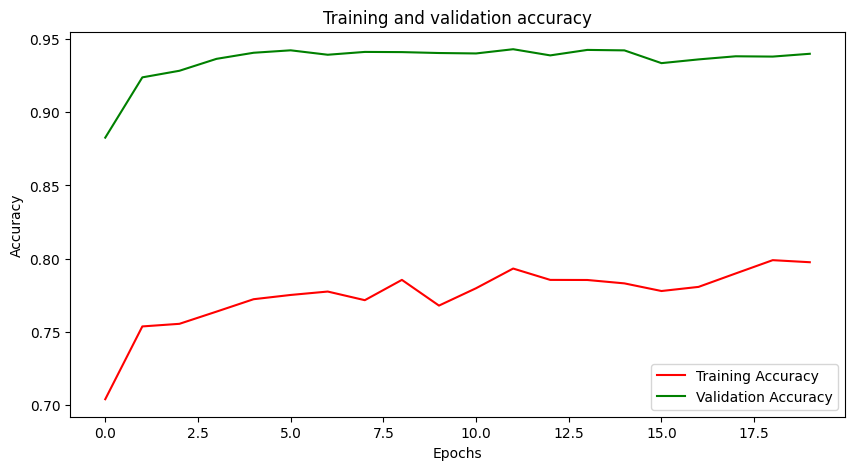

<Figure size 640x480 with 0 Axes>

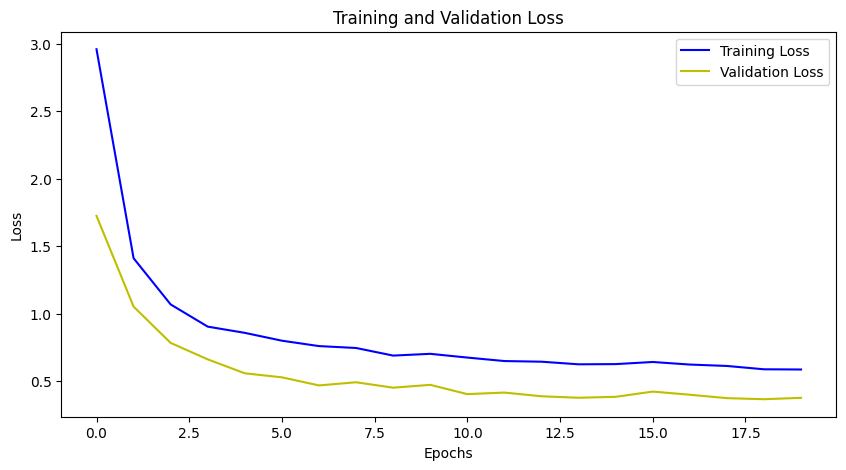

In [27]:
plot_acc_loss(acc, val_acc, loss, val_loss, epochs)

In [28]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")

4/4 [==============================] - 0s 23ms/step - loss: 0.4204 - accuracy: 0.9165
Test accuracy: 0.9165098071098328


In [29]:
model_file_name = f'U_net_model.h5'

# Save the Model
model.save(model_file_name)

In [20]:
model = load_model(f'U_net_model_1.h5')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 12  1308        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 12  48         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

                                                                  'batch_normalization_6[0][0]']  
                                                                                                  
 activation_5 (Activation)      (None, 32, 32, 64)   0           ['add_2[0][0]']                  
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 64)  0           ['activation_5[0][0]']           
                                                                                                  
 spatial_dropout2d_2 (SpatialDr  (None, 16, 16, 64)  0           ['max_pooling2d_2[0][0]']        
 opout2D)                                                                                         
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 128)  73856       ['spatial_dropout2d_2[0][0]']    
          

 activation_11 (Activation)     (None, 4, 4, 512)    0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 8, 8, 256)   524544      ['activation_11[0][0]']          
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 8, 8, 512)    0           ['conv2d_transpose[0][0]',       
                                                                  'activation_9[0][0]']           
                                                                                                  
 conv2d_19 (Conv2D)             (None, 8, 8, 256)    1179904     ['concatenate[0][0]']            
                                                                                                  
 batch_nor

                                                                                                  
 activation_17 (Activation)     (None, 32, 32, 64)   0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 64, 64, 32)  8224        ['activation_17[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_3 (Concatenate)    (None, 64, 64, 64)   0           ['conv2d_transpose_3[0][0]',     
                                                                  'activation_3[0][0]']           
                                                                                                  
 conv2d_28 (Conv2D)             (None, 64, 64, 32)   18464       ['concatenate_3[0][0]']          
          

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Function to calculate Intersection over Union (IoU)
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Predict on the test set
y_pred = model.predict(test_images)

# Check the range of predictions
print("Min prediction:", y_pred.min())
print("Max prediction:", y_pred.max())

# Adjust the threshold if necessary
threshold = 0.1  # You can try different values, like 0.3
y_pred = (y_pred > threshold).astype(np.uint8)

# Flatten the arrays for metric calculations
y_true_flat = test_labels.flatten()
y_pred_flat = y_pred.flatten()

# Calculate IoU
iou = iou_score(y_true_flat, y_pred_flat)
print(f"IoU: {iou:.4f}")

# Calculate Precision, Recall, and F1-Score with zero_division parameter
precision = precision_score(y_true_flat, y_pred_flat, zero_division=1)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

1/1 [==============================] - 6s 6s/step
Min prediction: 0.0003108078
Max prediction: 0.757123
IoU: 0.2444
Precision: 0.2462
Recall: 0.9721
F1-Score: 0.3929
